### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split as tts
import sys
import time
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import matplotlib.image as img

# CIFAR - 10 Dataset

In [4]:
#Loading Pre-processed dataset for Bonsai
dirc = './cifar10/'
Xtrain = np.load(dirc + 'Xtrain.npy').reshape(-1,32*32*3)
Ytrain = np.load(dirc + 'Ytrain.npy')

Xtrain, Xtest, Ytrain, Ytest = tts(Xtrain, Ytrain, stratify = Ytrain, test_size = 0.25)

In [5]:
# N, dDims = X_train.shape
N, dDims = Xtrain.shape
# nClasses = len(np.unique(Y_train))
nClasses = Ytrain.shape[1]
print('Training Size:',N,',Data Dims:', dDims,',No. Classes:', nClasses)

Training Size: 37500 ,Data Dims: 3072 ,No. Classes: 10


#### Visulaization

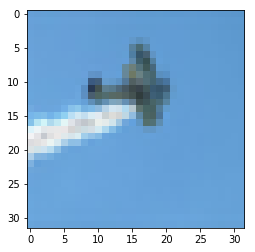

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [6]:
i = 420 # index of data object....
obj = Xtest[i].reshape(32,32,3)
plt.imshow(np.rollaxis(obj,1,0),cmap='gray')
plt.show()
print(Ytrain[i])

In [7]:
class Bonsai():
    def __init__(self, nClasses, dDims, pDims, tDepth, sigma, kernelsshp, strides, cDepth = 2, W=None, T=None, V=None, Z=None):
        '''
        dDims : data Dimensions
        pDims : projected Dimesions
        nClasses : num Classes
        tDepth : tree Depth
        
        Expected Dimensions:
        --------------------
        Bonsai Params // Optional
        
        W [numClasses*totalNodes, projectionDimension]
        V [numClasses*totalNodes, projectionDimension]
        Z [projectionDimension, dataDimension + 1]
        T [internalNodes, projectionDimension]

        internalNodes = 2**treeDepth - 1
        totalNodes = 2*internalNodes + 1

        sigma - tanh non-linearity
        sigmaI - Indicator function for node probabilities
        sigmaI - has to be set to infinity(1e9 for practicality)
        
        while doing testing/inference
        numClasses will be reset to 1 in binary case
        '''
        
        # Initialization of parameter variables
        
        self.dDims = dDims
        self.pDims = pDims
        
        # If number of classes is two we dont need to calculate other class probability
        if nClasses == 2:
            self.nClasses = 1
        else:
            self.nClasses = nClasses

        self.tDepth = tDepth
        self.sigma = sigma
        self.iNodes = 2**self.tDepth - 1
        self.tNodes = 2*self.iNodes + 1
        
        self.cDepth = cDepth
        self.ciNodes = 2**self.cDepth - 1
        self.ctNodes = 2*self.ciNodes + 1
        
        
        self.kernelsT = []
        
        self.strides = []
        
        self.channels = 3
        self.d1 = 32
        self.d2 = 32
        d1 = self.d1
        d2 = self.d2
        oD1 = d1
        oD2 = d2
        
        
        
        
        
        self.wts = []
        self.wts1 = []
        self.wts2 = []
        self.bs = []
        
        
        h = 0
        h_old = 0
        Codims1 = self.d1
        Codims2 = self.d2
        for i in range(self.ctNodes):
            
            h = int(np.floor(np.log(i+1)/np.log(2)))
            
            self.kernelsT.append(
                tf.get_variable('kernelT'+str(i), kernelsshp[h], 
                             initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32),
                             dtype=tf.float32)
            )
            
            self.strides.append(strides[h])
            
            
        for i in range(self.cDepth+1):
            Codims1 = np.floor((Codims1 - kernelsshp[i][0])/(strides[i][1])) + 1
            Codims2 = np.floor((Codims2 - kernelsshp[i][1])/(strides[i][2])) + 1
            
        print(Codims1,Codims2,self.ctNodes - self.ciNodes)
            
        self.CoDims = int(Codims1*Codims2) + 1
        self.pDims = self.CoDims
        
#         self.Z = tf.Variable(tf.random_normal([self.pDims, self.CoDims]), name='Z', dtype=tf.float32)
        self.Z = tf.Variable(tf.random_normal([2,2]), name='Z', dtype=tf.float32) 

        self.W = tf.Variable(tf.random_normal([self.ctNodes - self.ciNodes, self.nClasses * self.tNodes, self.pDims]), name='W', dtype=tf.float32)
        self.V = tf.Variable(tf.random_normal([self.ctNodes - self.ciNodes, self.nClasses * self.tNodes, self.pDims]), name='V', dtype=tf.float32)
        self.T = tf.Variable(tf.random_normal([self.ctNodes - self.ciNodes, self.iNodes, self.pDims]), name='T', dtype=tf.float32)
        
        
        self.score = None
        self.X_ = None
        self.prediction = None
        self.convs = []
        self.cnodeProb = []
        self.nodeProb = []
        self.scores = []
    
    def __call__(self, X, sigmaI):
        '''
        Function to build the Bonsai Tree graph
        
        Expected Dimensions
        -------------------
        X is [_, self.dDims]
        X_ is [_, self.pDims]
        '''
        errmsg = "Dimension Mismatch, X is [_, self.dataDimension]"
        assert (len(X.shape) == 2 and int(X.shape[1]) == self.dDims), errmsg
        
        sigmaI = tf.reshape(sigmaI, [1,1])
        
        # return score, X_ if exists where X_ is the projected X, i.e X_ = (Z.X)/(D^)
        if self.score is not None:
            return self.score, self.X_
        
        
        Ximg = tf.reshape(X, [-1,self.d1,self.d2,self.channels])
        
        self.convs = []
        
        
        # For Root Node score...
        self.__cnodeProb = [] # node probability list
        self.__cnodeProb.append(1) # probability of x passing through root is 1.
        
        # All score sums variable initialized to root score... for each tree (Note: can be negative)
        convT = 0.1*tf.nn.leaky_relu(tf.nn.conv2d(Ximg,
            self.kernelsT[0],
            padding="VALID",
            strides = self.strides[0]), name = 'convT0')
        
        self.convs.append(convT)
        
        flatConv = tf.layers.Flatten()(convT)
        b = tf.squeeze(flatConv.shape[1])
        self.wts.append(tf.Variable(tf.random_normal([1, b]), name='wts' + str(0), dtype=tf.float32))
        self.wts1.append(tf.Variable(tf.random_normal([1, b]), name='wts1' + str(0), dtype=tf.float32))
        self.wts2.append(tf.Variable(tf.random_normal([1, b]), name='wts2' + str(0), dtype=tf.float32))
        self.bs.append(tf.Variable(tf.random_normal([1, 1]), name='bs' + str(0), dtype=tf.float32))
        
        finalImg =  None
        
        
        fscore_ = None
        fX_ = None
        self.__nodeProbs = []
        
        for i in range(1,self.ctNodes):
#             print(convT.shape, len(self.__cnodeProb))
            parent_id = int(np.ceil(i / 2.0) - 1.0)
            
            convTprev = self.convs[parent_id]
            flatConvP = tf.layers.Flatten()(convTprev)
            
            
            cscore = tf.multiply(sigmaI, tf.matmul(self.wts[parent_id], flatConvP, transpose_b = True) + self.bs[parent_id])# 1 x _
            
            # Calculating probability that x should come to this node next given it is in parent node...
            cprob = tf.divide((1 + ((-1)**(i + 1))*tf.tanh(cscore)),2.0) # : scalar 1 x_
            cprob = self.__cnodeProb[parent_id] * cprob # : scalar 1 x _
            
            
            # adding prob to node prob list
            self.__cnodeProb.append(cprob)
            
            convT = 0.1*tf.nn.leaky_relu(tf.nn.conv2d(convTprev,
                self.kernelsT[i],
                padding="VALID",
                strides = self.strides[i]), name = 'convT' + str(i))
            
            self.convs.append(convT)
#             print(self.convs[i].shape)
            
            
            flatConv = tf.layers.Flatten()(convT)
            b = tf.squeeze(flatConv.shape[1])
            
            self.wts.append(tf.Variable(tf.random_normal([1, b]), name='wts' + str(i), dtype=tf.float32))
            self.wts1.append(tf.Variable(tf.random_normal([1, b]), name='wts1' + str(i), dtype=tf.float32))
            self.wts2.append(tf.Variable(tf.random_normal([1, b]), name='wts2' + str(i), dtype=tf.float32))
            self.bs.append(tf.Variable(tf.random_normal([1, 1]), name='bs' + str(i), dtype=tf.float32))
            

            
            if(i+1 > self.ciNodes):
                # projected output of convolutional layers....
                
                iinum = i - self.ciNodes
                
                a,b = flatConv.shape
                onesmat = flatConv[:,0:1]*0 + 1

                flat_imgs = tf.concat([flatConv, onesmat], axis = 1)
                
#                 print(self.Z[iinum,:,:].shape, flatConv.shape, flat_imgs.shape)
                
#                 X_ = tf.divide(tf.matmul(self.Z[iinum,:,:], flat_imgs, transpose_b=True),self.pDims) # dimensions are D^x_
                X_ = tf.transpose(flat_imgs)#tf.matmul(self.Z, flat_imgs, transpose_b = True)
#                 print(X_)
                # For Root Node score...
                tnodeProb = [] # node probability list
                tnodeProb.append(cprob) # probability of x passing through root is 1.
                W_ = self.W[iinum, 0:(self.nClasses),:]# first K trees root W params : KxD^
                V_ = self.V[iinum, 0:(self.nClasses),:]# first K trees root V params : KxD^

                # All score sums variable initialized to root score... for each tree (Note: can be negative)
                score_ = tnodeProb[0]*tf.multiply(tf.matmul(W_, X_), tf.tanh(self.sigma * tf.matmul(V_, X_))) # : Kx_
                self.scores.append(flat_imgs)
#                 print(score_)
        #         print(score_.shape)

                # Adding rest of the nodes scores...
                for t in range(1, self.tNodes):
                    # current node is i
                    # W, V of K different trees for current node
                    W_ = self.W[iinum,t * self.nClasses:((t + 1) * self.nClasses),:]# : KxD^
                    V_ = self.V[iinum,t * self.nClasses:((t + 1) * self.nClasses),:]# : KxD^


                    # i's parent node shared theta param reshaping to 1xD^
                    T_ = tf.reshape(self.T[iinum,int(np.ceil(t / 2.0) - 1.0),:],[-1, self.pDims])# : 1xD^

                    # Calculating probability that x should come to this node next given it is in parent node...
                    prob = tf.divide((1 + ((-1)**(t + 1))*tf.tanh(tf.multiply(sigmaI, tf.matmul(T_, X_)))),2.0) # : scalar 1x_

                    # Actual probability that x will come to this node...p(parent)*p(this|parent)...
                    prob = tnodeProb[int(np.ceil(t / 2.0) - 1.0)] * prob # : scalar 1x_

                    # adding prob to node prob list
                    tnodeProb.append(prob)
                    # New score addes to sum of scores...
                    score_ += tnodeProb[t]*tf.multiply(tf.matmul(W_, X_), tf.tanh(self.sigma * tf.matmul(V_, X_))) # Kx_
                
                self.scores.append(score_)
                self.__nodeProbs.append(tnodeProb[1:])
                
                if(fscore_ is None):
                    fscore_ = score_
                    fX_ = tf.matmul(T_, X_)*cprob
                else:
                    fscore_ = fscore_ + score_
                    fX_ = fX_ + tf.matmul(T_, X_)*cprob
            else:
                pass
                if(fscore_ is None):
                    W_ = self.wts1[i]
                    V_ = self.wts2[i]
                    X_ = flatConv
                    fscore_ = cprob*tf.multiply(tf.matmul(W_, X_, transpose_b = True), tf.tanh(self.sigma * tf.matmul(V_, X_, transpose_b = True))) # Kx_
                    fX_ = cscore*cprob
                else:
                    W_ = self.wts1[i]
                    V_ = self.wts2[i]
                    X_ = flatConv
                    fscore_ = fscore_ + cprob*tf.multiply(tf.matmul(W_, X_, transpose_b = True), tf.tanh(self.sigma * tf.matmul(V_, X_, transpose_b = True))) # Kx_
                    fX_ = fX_ + cscore*cprob

                
        self.score = fscore_ #- tf.reduce_min(fscore_,axis=0) + 0.00000000000000000000000000001
        self.X_ = fX_
        self.nodeProb = tf.convert_to_tensor(self.__nodeProbs[:])
        self.cnodeProb = tf.convert_to_tensor(self.__cnodeProb[1:])
        self.layers = self.convs
#         print(self.score,cprob.shape, T_.shape, X_.shape)
        return self.score, self.X_
                
   
        
    
    def predict(self):
        '''
        Takes in a score tensor and outputs a integer class for each data point
        '''
        if self.prediction is not None:
            return self.prediction
        
        # If number of classes is two we dont need to calculate other class probability
        if self.nClasses > 2:
            # Finding argmax over first axis (k axis)
            self.prediction = tf.argmax(tf.transpose(self.score), 1) # score is 1xk
        else:
            # Finding argmax over score and 0 score is 1x1
            self.prediction = tf.argmax(tf.concat([tf.transpose(self.score),0*tf.transpose(self.score)], 1), 1)
        return self.prediction

    def assert_params(self):
        
        # Asserting Initializaiton
        
        errRank = "All Parameters must has only two dimensions shape = [a, b]"
        assert len(self.W.shape) == len(self.Z.shape), errRank
        assert len(self.W.shape) == len(self.T.shape), errRank
        assert len(self.W.shape) == 2, errRank
        msg = "W and V should be of same Dimensions"
        assert self.W.shape == self.V.shape, msg
        errW = "W and V are [numClasses*totalNodes, projectionDimension]"
        assert self.W.shape[0] == self.nClasses * self.tNodes, errW
        assert self.W.shape[1] == self.pDims, errW
        errZ = "Z is [projectionDimension, dataDimension]"
        assert self.Z.shape[0] == self.pDims, errZ
        assert self.Z.shape[1] == self.dDims, errZ
        errT = "T is [internalNodes, projectionDimension]"
        assert self.T.shape[0] == self.iNodes, errT
        assert self.T.shape[1] == self.pDims, errT
        assert int(self.nClasses) > 0, "numClasses should be > 1"
        msg = "# of features in data should be > 0"
        assert int(self.dDims) > 0, msg
        msg = "Projection should be  > 0 dims"
        assert int(self.pDims) > 0, msg
        msg = "treeDepth should be >= 0"
        assert int(self.tDepth) >= 0, msg

In [ ]:
class BonsaiTrainer():
    
    def __init__(self, tree, lW, lT, lV, lZ, lr, X, Y, sW, sV, sZ, sT):
        
        '''
        bonsaiObj - Initialised Bonsai Object and Graph...
        lW, lT, lV and lZ are regularisers to Bonsai Params...
        sW, sT, sV and sZ are sparsity factors to Bonsai Params...
        lr - learningRate fro optimizer...
        X is the Data Placeholder - Dims [_, dataDimension]
        Y - Label placeholder for loss computation
        useMCHLoss - For choice between HingeLoss vs CrossEntropy
        useMCHLoss - True - MultiClass - multiClassHingeLoss
        useMCHLoss - False - MultiClass - crossEntropyLoss
        '''
        #  Intializations of training parameters
        self.tree = tree
        
        # regularization params lambdas(l) (all are scalars)
        self.lW = lW
        self.lV = lV
        self.lT = lT
        self.lZ = lZ

        # sparsity parameters (scalars all...) will be used to calculate percentiles to make other cells zero
        self.sW = sW 
        self.sV = sV
        self.sT = sT
        self.sZ = sZ

        # placeholders for inputs and labels
        self.Y = Y # _ x nClasses
        self.X = X # _ x D
        
        # learning rate
        self.lr = lr
        
        # Asserting initialization
        self.assert_params()
        
        # place holder for path selection parameter sigmaI
        self.sigmaI = tf.placeholder(tf.float32, name='sigmaI')
        # invoking __call__ of tree getting initial values of score and projected X
        self.score, self.X_ = self.tree(self.X, self.sigmaI)
        # defining loss function tensorflow graph variables.....
        self.loss, self.marginLoss, self.regLoss = self.lossGraph()
        # defining single training step graph process ...
        self.tree.TrainStep = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        self.trainStep = self.tree.TrainStep
        # defining accuracy and prediction graph objects
        self.accuracy = self.accuracyGraph()
        self.prediction = self.tree.predict()
        
        
        # set all parameters above 0.99 if dont want to use IHT
        if self.sW > 0.99 and self.sV > 0.99 and self.sZ > 0.99 and self.sT > 0.99:
            self.isDenseTraining = True
        else:
            self.isDenseTraining = False
            
        # setting the hard thresholding graph obejcts
        self.hardThrsd()
        
    def hardThrsd(self):
        '''
        Set up for hard Thresholding Functionality
        '''
        # place holders for sparse parameters....
        self.__Wth = tf.placeholder(tf.float32, name='Wth')
        self.__Vth = tf.placeholder(tf.float32, name='Vth')
        self.__Zth = tf.placeholder(tf.float32, name='Zth')
        self.__Tth = tf.placeholder(tf.float32, name='Tth')

        # assigning the thresholded values to params as a graph object for tensorflow....
        self.__Woph = self.tree.W.assign(self.__Wth)
        self.__Voph = self.tree.V.assign(self.__Vth)
        self.__Toph = self.tree.T.assign(self.__Tth)
        self.__Zoph = self.tree.Z.assign(self.__Zth)

        # grouping the graph objects as one object....
        self.hardThresholdGroup = tf.group(
            self.__Woph, self.__Voph, self.__Toph, self.__Zoph)
        
    def hardThreshold(self, A, s):
        '''
        Hard thresholding function on Tensor A with sparsity s
        '''
        # copying to avoid errors....
        A_ = np.copy(A)
        # flattening the tensor...
        A_ = A_.ravel()
        if len(A_) > 0:
            # calculating the threshold value for sparse limit...
            th = np.percentile(np.abs(A_), (1 - s) * 100.0, interpolation='higher')
            # making sparse.......
            A_[np.abs(A_) < th] = 0.0
        # reconstructing in actual shape....
        A_ = A_.reshape(A.shape)
        return A_

    def accuracyGraph(self):
        '''
        Accuracy Graph to evaluate accuracy when needed
        '''
        if (self.tree.nClasses > 2):
            correctPrediction = tf.equal(tf.argmax(tf.transpose(self.score), 1), tf.argmax(self.Y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))
        else:
            # some accuracy functional analysis for 2 classes could be different from this...
            y_ = self.Y * 2 - 1
            correctPrediction = tf.multiply(tf.transpose(self.score), y_)
            correctPrediction = tf.nn.relu(correctPrediction)
            correctPrediction = tf.ceil(tf.tanh(correctPrediction)) # final predictions.... round to(0 or 1)
            self.accuracy = tf.reduce_mean(
                tf.cast(correctPrediction, tf.float32))

        return self.accuracy
        
    
    def lossGraph(self):
        '''
        Loss Graph for given tree
        '''
        # regularization losses.....
        self.regLoss = 0.5 * (self.lZ * tf.square(tf.norm(self.tree.Z)) +
                          self.lW * tf.square(tf.norm(self.tree.W)) +
                          self.lV * tf.square(tf.norm(self.tree.V)) +
                          self.lT * tf.square(tf.norm(self.tree.T)))
        
        llen = self.tree.ciNodes
        var = 0
        for i in range(llen):
            var = var +  self.lT * tf.square(tf.norm(self.tree.wts[i]))
            var = var + self.lW * tf.square(tf.norm(self.tree.wts1[i]))
            var = var + self.lV * tf.square(tf.norm(self.tree.wts2[i]))
            
        self.regLoss = self.regLoss + var
        
        # emperical actual loss.....
        if (self.tree.nClasses > 2):
            '''
            Cross Entropy loss for MultiClass case in joint training for
            faster convergence
            '''
            # cross entropy loss....
            self.marginLoss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits_v2(logits=tf.transpose(self.score),
                                                               labels=tf.stop_gradient(self.Y)))
        else:
            # sigmoid loss....
            self.marginLoss = tf.reduce_mean(tf.nn.relu(1.0 - (2 * self.Y - 1) * tf.transpose(self.score)))
    
        # adding the losses...
        self.loss = self.marginLoss + self.regLoss
        return self.loss, self.marginLoss, self.regLoss
        
    def assert_params(self):
        # asserting the initialization....
        err = "sparsity must be between 0 and 1"
        assert self.sW >= 0 and self.sW <= 1, "W " + err
        assert self.sV >= 0 and self.sV <= 1, "V " + err
        assert self.sZ >= 0 and self.sZ <= 1, "Z " + err
        assert self.sT >= 0 and self.sT <= 1, "T " + err
        errMsg = "Dimension Mismatch, Y has to be [_, " + str(self.tree.nClasses) + "]"
        errCont = " numClasses are 1 in case of Binary case by design"
        assert (len(self.Y.shape) == 2 and self.Y.shape[1] == self.tree.nClasses), errMsg + errCont
        
        

        
    def train(self, batchSize, totalEpochs, sess, Xtrain, Xval, Ytrain, Yval, saver, filename,valsig):
        iht = 0 # to keep a note if thresholding has been started ...
        numIters = Xtrain.shape[0] / batchSize # number of batches at a time...
        totalBatches = numIters * totalEpochs # total number of batch operations...
        treeSigmaI = valsig # controls the fidelity of the approximation too high can saturate tanh.
            
        maxTestAcc = -10000
        itersInPhase = 0
        
        for i in range(totalEpochs):
            print("\nEpoch Number: " + str(i))
            # defining training acc and loss
            trainAcc = 0.0
            trainAccOld = 0.0
            trainLoss = 0.0
            trainBest = 0.0
            
            numIters = int(numIters)
            
            for j in range(numIters):
                # creating batch.....sequentiall could be done randomly using choice function...
                mini_batchX = Xtrain[j*batchSize:(j+1)*batchSize,:] # B x D
                mini_batchY = Ytrain[j*batchSize:(j+1)*batchSize] # B x 
            
                # feed for training using tensorflow graph based gradient descent approach......
                _feed_dict = {self.X: mini_batchX, self.Y: mini_batchY,
                                  self.sigmaI: treeSigmaI}
                
                # training the tensorflow graph
                _, batchLoss, batchAcc = sess.run(
                    [self.trainStep, self.loss, self.accuracy],
                    feed_dict=_feed_dict)
                
                # calculating acc....
                trainAcc += batchAcc
                trainLoss += batchLoss
                
                
                
                # to update sigmaI.....
                if ((itersInPhase+1) % 100 == 0):
                    
                    # Making a random batch....
                    indices = np.random.choice(Xtrain.shape[0], 100)
                    rand_batchX = Xtrain[indices, :]
                    rand_batchY = Ytrain[indices, :]
                    rand_batchY = np.reshape(rand_batchY, [-1, self.tree.nClasses])

                    _feed_dict = {self.X: rand_batchX,
                                  self.sigmaI: treeSigmaI}
                    # Projected matrix...
                    Xcapeval = self.X_.eval(feed_dict=_feed_dict) # D^ x 1
                    # theta value... current...
#                     Teval = self.tree.T.eval() # iNodes x D^
                    # current sum of all internal nodes sum(abs(theta^T.Z.x): iNoddes x miniBS) : 1x1
                    sum_tr = 0.0 
                    for k in range(0, self.tree.iNodes):
                        sum_tr += (np.sum(np.abs(Xcapeval)))

                    
                    if(self.tree.iNodes > 0):
                        sum_tr /= (self.tree.iNodes) # normalizing all sums
                        sum_tr = 1 / sum_tr # inverse of average sum
                    else:
                        sum_tr = 0.1
                    # thresholding inverse of sum as min(1000, sum_inv*2^(cuurent batch number / total bacthes / 30))
                    sum_tr = min(
                        1000, sum_tr * (2**(float(itersInPhase) /
                                            (float(totalBatches) )))*valsig/30)
                    # assiging higher values as convergence is reached...
                    treeSigmaI = sum_tr
                    
                itersInPhase+=1
                
                
                # to start hard thresholding after half_time(could vary) ......
                if((itersInPhase//numIters > (1/2)*totalEpochs) and (not self.isDenseTraining)):
                    if(iht == 0):
                        print('\n\nHard Thresolding Started\n\n')
                        iht = 1
                    
                    # getting the current estimates of  W,V,Z,T...
                    currW = self.tree.W.eval()
                    currV = self.tree.V.eval()
                    currZ = self.tree.Z.eval()
                    currT = self.tree.T.eval()

                    # Setting a method to make some values of matrix zero....
                    self.__thrsdW = self.hardThreshold(currW, self.sW)
                    self.__thrsdV = self.hardThreshold(currV, self.sV)
                    self.__thrsdZ = self.hardThreshold(currZ, self.sZ)
                    self.__thrsdT = self.hardThreshold(currT, self.sT)

                    # runnign the hard thresholding graph....
                    fd_thrsd = {self.__Wth: self.__thrsdW, self.__Vth: self.__thrsdV,
                                self.__Zth: self.__thrsdZ, self.__Tth: self.__thrsdT}
                    sess.run(self.hardThresholdGroup, feed_dict=fd_thrsd)
                    
            
            
            print("Train Loss: " + str(trainLoss / numIters) +
                  " Train accuracy: " + str(trainAcc / numIters))
            print("SigmaI :",treeSigmaI)
            
            if(((trainAcc / numIters) - trainAccOld) < -0.1):
#                 saver.restore(sess, filename)
                self.lr = tf.math.minimum(self.lr/10, 0.00001)
#                 self.tree.sigma = tf.math.minimum(self.tree.sigma/10, 0.001)
                trainAccOld = trainAcc/numIters 

            else:
                self.lr = tf.math.maximum(self.lr*10, 0.1)
#                 self.tree.sigma = tf.math.maximum(self.tree.sigma*10, 1)
                trainAccOld = trainAcc/numIters 
#                 saver.save(sess, filename)

            
                
        
        
            if((trainAcc / numIters) <= trainBest):
                pass
            else:
                trainBest = trainAcc/numIters 
                saver.save(sess, filename + "/model_best")
                
            
            # calculating the test accuracies with sigmaI as expected -> inf.. = 10^9
            oldSigmaI = treeSigmaI
            treeSigmaI = 1e9
            
            # test feed for tf...
            _feed_dict = {self.X: Xval, self.Y: Yval,
                                  self.sigmaI: treeSigmaI}
            
            # calculating losses....
            testAcc, testLoss, regTestLoss = sess.run([self.accuracy, self.loss, self.regLoss], feed_dict=_feed_dict)
            
            if(testLoss == np.nan or regTestLoss == np.nan):
                print("getting nan")
                saver.restore(sess, filename)
                self.lr = self.lr/10
            
            if maxTestAcc <= testAcc:
                maxTestAccEpoch = i
                maxTestAcc = testAcc
            
            print("Test accuracy %g" % testAcc)
            print("MarginLoss + RegLoss: " + str(testLoss - regTestLoss) +
                  " + " + str(regTestLoss) + " = " + str(testLoss) + "\n", end='\r')
#             time.sleep(0.1)
#             clear_output()
            
            
            treeSigmaI = oldSigmaI
            
        # sigmaI has to be set to infinity to ensure
        # only a single path is used in inference
        treeSigmaI = 1e9
        print("\nMaximum Test accuracy at compressed" +
              " model size(including early stopping): " +
              str(maxTestAcc) + " at Epoch: " +
              str(maxTestAccEpoch + 1) + "\nFinal Test" +
              " Accuracy: " + str(testAcc))

In [30]:
tf.reset_default_graph()
kernelsshp = [[4,4,3,2],[4,4,2,1],[3,3,1,1],[3,3,2,1],[3,3,1,1],[3,3,1,1],[3,3,1,1]]
strides = [[1,2,2,1],[1,2,2,1],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]]
tree = Bonsai(nClasses = nClasses, dDims = dDims, pDims = 28, tDepth = 2, sigma = 1,
              kernelsshp = kernelsshp, strides = strides , cDepth = 2)
X = tf.placeholder("float32", [None, dDims])
Y = tf.placeholder("float32", [None, nClasses])
bonsaiTrainer = BonsaiTrainer(tree, lW = 0.1, lT = 0.1, lV = 0.1, lZ = 0.00, lr = 0.001, X = X, Y = Y,
                              sZ = 0.995, sW = 0.995, sV = 0.995, sT = 0.995)
init_op = tf.global_variables_initializer()

4.0 4.0 4


In [31]:
filename = "./bonsaiconvdiff/Nov17_1_19pm/model"
with tf.Session() as sess:
    saver = tf.train.Saver()
#     saver.restore(sess, filename+'19')
    sess.run(init_op)
    saver.save(sess, filename+'last')
    totalEpochs = 100
    bonsaiTrainer.lr = 0.1
    bonsaiTrainer.lZ = 0.0
    bonsaiTrainer.tree.sigma = 0.00001
    batchSize = np.maximum(5000, int(np.ceil(np.sqrt(Ytrain.shape[0]))))
    for i in range(20):
        bonsaiTrainer.train(batchSize, totalEpochs, sess, Xtrain, Xtest, Ytrain, Ytest, saver, filename,1)
        saver.save(sess, filename+str(i))
        print("Done sequence ", i)


Epoch Number: 0
Train Loss: 640.2631574358259 Train accuracy: 0.10162857068436486
SigmaI : 1
Test accuracy 0.10472
MarginLoss + RegLoss: 3.076416 + 633.5638 = 636.6402

Epoch Number: 1
Train Loss: 633.1539481026786 Train accuracy: 0.10162857174873352
SigmaI : 1
Test accuracy 0.1088
MarginLoss + RegLoss: 3.034546 + 626.5118 = 629.5463

Epoch Number: 2
Train Loss: 626.120361328125 Train accuracy: 0.10162857174873352
SigmaI : 1
Test accuracy 0.10288
MarginLoss + RegLoss: 3.0992432 + 619.53577 = 622.635

Epoch Number: 3
Train Loss: 619.1657453264509 Train accuracy: 0.10194285746131625
SigmaI : 1
Test accuracy 0.1036
MarginLoss + RegLoss: 3.069641 + 612.6392 = 615.70886

Epoch Number: 4
Train Loss: 612.291765485491 Train accuracy: 0.1023428567818233
SigmaI : 1


KeyboardInterrupt: 

In [20]:
def calc_zero_ratios(tree):
    zs = np.sum(np.abs(tree.Z.eval())<0.000000000000001)/(tree.Z.eval()!=None).sum()
    ws = np.sum(np.abs(tree.W.eval())<0.000000000000001)/(tree.W.eval()!=None).sum()
    vs = np.sum(np.abs(tree.V.eval())<0.000000000000001)/(tree.V.eval()!=None).sum()
    ts = np.sum(np.abs(tree.T.eval())<0.000000000000001)/(tree.T.eval()!=None).sum()
    print('Sparse ratios achieved...\nW:',1-ws,'\nV:',1-vs,'\nT:',1-ts,'\nZ:',1-zs)

In [384]:
# prediction...
sub = pd.read_csv('./cifartest/submission.csv')

In [385]:
subarr = sub.values

In [386]:
subarr.shape

(300000, 2)

In [387]:
Xtrain.shape

(37500, 3072)

In [388]:
image = img.imread('./cifartest/cifartest/test/1234.png')

iii = 780
image = np.flip(np.rollaxis(image.reshape(32,32,3),1,0),axis = 0)
# image = Xtrain[1000].reshape(32,32,3)
image.shape

(32, 32, 3)

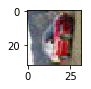

In [389]:
figure = plt.figure(figsize=[1,1])
plt.imshow(image)
plt.show()

In [390]:
Xtrain[iii], (image.reshape(-1,3072)[0]*255).astype(int)

(array([87, 85, 73, ..., 65, 59, 66], dtype=uint8),
 array([ 87,  89, 117, ..., 148, 142, 111]))

In [391]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, filename+'0')
    calc_zero_ratios(tree)
    _feed_dict = {bonsaiTrainer.X:(image*255).astype(int).reshape(-1,3072),bonsaiTrainer.sigmaI:float(1000.0)}
    val = sess.run(tree.prediction, feed_dict=_feed_dict)
    
#     for item in val:
#         print(item.shape)

    print(val)

INFO:tensorflow:Restoring parameters from ./bonsaiconvdiff/Nov13_8_16pm/model0
Sparse ratios achieved...
W: 1.0 
V: 1.0 
T: 1.0 
Z: 1.0
[9]


In [320]:
fig = plt.figure(figsize = [1,1])
plt.imshow(val[0][2][:,:,9])

IndexError: invalid index to scalar variable.

<Figure size 72x72 with 0 Axes>

In [321]:
tree.score

<tf.Tensor 'add_62:0' shape=(10, ?) dtype=float32>

In [322]:
labellist = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [325]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, filename+'0')

    for i in range(300000):
        image = img.imread('./cifartest/cifartest/test/'+str(i+1)+'.png')
        image = np.rollaxis(image,1,0)
        _feed_dict = {bonsaiTrainer.X:(image*255).astype(int).reshape(-1,3072),bonsaiTrainer.sigmaI:float(1)}
        val = sess.run(tree.prediction, feed_dict=_feed_dict)[0]
        labelobt = labellist[val]
        subarr[i,1] = labelobt
        if((i)%10000 == 0):
            print('the total parts',i, 'out of 300000 done')

INFO:tensorflow:Restoring parameters from ./bonsaiconvdiff/Nov12_9_36pm/model0
the total parts 0 out of 300000 done
the total parts 10000 out of 300000 done
the total parts 20000 out of 300000 done
the total parts 30000 out of 300000 done
the total parts 40000 out of 300000 done
the total parts 50000 out of 300000 done
the total parts 60000 out of 300000 done
the total parts 70000 out of 300000 done
the total parts 80000 out of 300000 done
the total parts 90000 out of 300000 done
the total parts 100000 out of 300000 done
the total parts 110000 out of 300000 done
the total parts 120000 out of 300000 done
the total parts 130000 out of 300000 done
the total parts 140000 out of 300000 done
the total parts 150000 out of 300000 done
the total parts 160000 out of 300000 done
the total parts 170000 out of 300000 done
the total parts 180000 out of 300000 done
the total parts 190000 out of 300000 done
the total parts 200000 out of 300000 done
the total parts 210000 out of 300000 done
the total p

In [328]:
new_subm = pd.DataFrame(subarr)

In [329]:
new_subm.head()

,0,1
0,1,horse
1,2,airplane
2,3,dog
3,4,airplane
4,5,ship


In [330]:
new_subm = new_subm.rename(columns={0: 'id', 1: 'label'})

In [331]:
new_subm['label'].unique()

array(['horse', 'airplane', 'dog', 'ship', 'cat', 'truck', 'automobile',
       'deer', 'frog', 'bird'], dtype=object)

In [332]:
new_subm.head()

,id,label
0,1,horse
1,2,airplane
2,3,dog
3,4,airplane
4,5,ship


In [333]:
new_subm.to_csv('submission_01.csv', index=False)

# thankyou